# Importing useful modules

In [1]:
%matplotlib inline

In [2]:
from __future__ import division #Importer ça avant toute chose, autrement ne marche pas
import graphlab as gl
#import pandas as pd
gl.canvas.set_target('ipynb') # Pour afficher les graphes dans mon notebook plutôt que new tab

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import pcolor, show, colorbar, xticks, yticks
import seaborn as sns

In [4]:
def sum(a,b):
    print a+b
    
my_tuple = (1,2)
sum(*my_tuple)

3


# Functions definitions

In [6]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

In [7]:
def plot_corr(df,size=8):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    pcolor(corr)
    colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [8]:
#prediction_validation is the prediction done on the validation data using the validation set
#validation_data is the validation set
def calc_accuracy(prediction_validation, validation_data):
    accuracy = ((prediction_validation==validation_data["Survived"]).sum())/len(validation_data)
    return accuracy
#print("Accuracy of the model : %.3f" %accuracy)

In [9]:
#All babies should have age 0
def age_change(age):
    if age<=1:
        return 0
    else:
        return age

In [42]:
def tree_model(data, features,MLR,MCW):
    return gl.decision_tree_classifier.create(data,features = features, target = target, 
                                              validation_set=None, min_loss_reduction = MLR,
                                             verbose = None, min_child_weight = MCW, max_depth=3)

# Importing csv files

In [11]:
#Let's work with pandas then import in graphlab
df_data = pd.read_csv("./train.csv") #My training data
data_raw = gl.SFrame.read_csv("./train.csv")

This non-commercial license of GraphLab Create for academic use is assigned to docteur.zuf@gmail.com and will expire on May 23, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Michael\AppData\Local\Temp\graphlab_server_1489263876.log.0


Finished parsing file C:\Users\Michael\Python notebooks\Kaggle-Titanic\train.csv

Parsing completed. Parsed 100 lines in 0.01655 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,long,str,str,float,long,long,str,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\Michael\Python notebooks\Kaggle-Titanic\train.csv

Parsing completed. Parsed 891 lines in 0.01401 secs.

In [12]:
df_data_validation = pd.read_csv("./test.csv") #Data used for submission to Kaggle
data_validation_raw = gl.SFrame.read_csv("./test.csv")

Finished parsing file C:\Users\Michael\Python notebooks\Kaggle-Titanic\test.csv

Parsing completed. Parsed 100 lines in 0.012009 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,str,str,float,long,long,str,float,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\Michael\Python notebooks\Kaggle-Titanic\test.csv

Parsing completed. Parsed 418 lines in 0.011509 secs.

# Let's look at the data

In [13]:
data_raw.show()

In [14]:
data_raw["Pclass"].show(view = "Categorical")

In [15]:
data_raw["Sex"].show()

In [16]:
Similar operations are done on the validation set

SyntaxError: invalid syntax (<ipython-input-16-2e430d9452a5>, line 1)

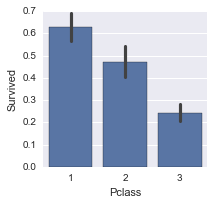

In [17]:
plot_categories( df_data , cat = 'Pclass' , target = 'Survived' )

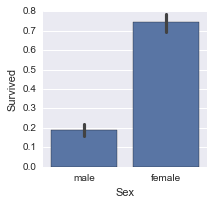

In [18]:
plot_categories(df_data, cat='Sex', target="Survived")

# Performing some data manipulation

In [19]:
#Let's remove unused columns for clarity (not necessary)
del df_data["Name"]
#del df_data["SibSp"]
#del df_data['Parch']
del df_data["Ticket"]
del df_data["Cabin"]
del df_data["Embarked"]
del df_data_validation["Name"]
#del df_data_validation["SibSp"]
#del df_data_validation['Parch']
del df_data_validation["Ticket"]
del df_data_validation["Cabin"]
del df_data_validation["Embarked"]

### Let's examine the feature "Age" for which we have to fill in the missing values

Age is not defined for all data points, we have to find a way to deal with this feature.
### Let's try a simple aproach
* if fare is 0 and age is not defined then probably we have a baby and age=0
* if age is <1 then age = 0 (baby)

Do we still have Nan values ?

In [20]:
df_data["Age"] = df_data["Age"].apply(age_change)
df_data_validation["Age"] = df_data_validation["Age"].apply(age_change)

Some passenger did not pay for the travel (Fare==0) and age is not defined, they probably are babies so let's change their age to 0.

In [21]:
df_data_validation[df_data_validation["Age"].isnull() & (df_data_validation["Fare"]==0)]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
266,1158,1,male,NaN,0,0,0.0


In [22]:
df_data[df_data["Age"].isnull() & (df_data["Fare"]==0)]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
277,278,0,2,male,NaN,0,0,0.0
413,414,0,2,male,NaN,0,0,0.0
466,467,0,2,male,NaN,0,0,0.0
481,482,0,2,male,NaN,0,0,0.0
633,634,0,1,male,NaN,0,0,0.0
674,675,0,2,male,NaN,0,0,0.0
732,733,0,2,male,NaN,0,0,0.0
815,816,0,1,male,NaN,0,0,0.0


In [23]:
df_data.loc[(df_data.Age.isnull()) & (df_data["Fare"] == 0), "Age"] = 0

In [24]:
df_data_validation.loc[(df_data_validation.Age.isnull()) & (df_data_validation["Fare"] == 0), "Age"] = 0

Then we will fill the remaining missing values with the mean of the age. BUT, I make the assumption that the mean age will depend on the class (rich people in 1st class will probably be older)

In [25]:
mean_age_Class1 = round(df_data["Age"][df_data["Pclass"]==1].mean()) #38 
mean_age_Class2 = round(df_data["Age"][df_data["Pclass"]==2].mean()) #30
mean_age_Class3 = round(df_data["Age"][df_data["Pclass"]==3].mean()) #25

In [26]:
df_data.loc[(df_data.Age.isnull()) & (df_data["Pclass"] == 1), "Age"] = mean_age_Class1
df_data.loc[(df_data.Age.isnull()) & (df_data["Pclass"] == 2), "Age"] = mean_age_Class2
df_data.loc[(df_data.Age.isnull()) & (df_data["Pclass"] == 3), "Age"] = mean_age_Class3

df_data["Is_baby"] = 0

df_data.loc[(df_data.Age < 4), "Is_baby"] = 1

What are the mean ages for the validation set ?

In [27]:
mean_age_Class1_valid = round(df_data_validation["Age"][df_data_validation["Pclass"]==1].mean()) #41 
mean_age_Class2_valid = round(df_data_validation["Age"][df_data_validation["Pclass"]==2].mean()) #29
mean_age_Class3_valid = round(df_data_validation["Age"][df_data_validation["Pclass"]==3].mean()) #24

In [28]:
df_data_validation.loc[(df_data_validation.Age.isnull()) & (df_data_validation["Pclass"] == 1), "Age"] = mean_age_Class1_valid
df_data_validation.loc[(df_data_validation.Age.isnull()) & (df_data_validation["Pclass"] == 2), "Age"] = mean_age_Class2_valid
df_data_validation.loc[(df_data_validation.Age.isnull()) & (df_data_validation["Pclass"] == 3), "Age"] = mean_age_Class3_valid

df_data_validation["Is_baby"] = 0

df_data_validation.loc[(df_data.Age < 4), "Is_baby"] = 1

Let's create some categorical features

In [29]:
df_data.loc[(df_data.Pclass == 1), "Pclass1"] = 1
df_data.loc[(df_data.Pclass == 2), "Pclass2"] = 1
df_data.loc[(df_data.Pclass == 3), "Pclass3"] = 1
df_data = df_data.fillna(0)

Plot of the correlation matrix

In [30]:
df_data_viz = pd.DataFrame(df_data)
del df_data_viz["Sex"]
del df_data_viz["Is_baby"]
#del df_data_viz["Pclass1"]
#del df_data_viz["Pclass2"]
#del df_data_viz["Pclass3"]

In [31]:
df_data_viz.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Pclass1,Pclass2,Pclass3
0,1,0,3,22.0,1,0,7.2500,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,1.0,0.0,0.0
4,5,0,3,35.0,0,0,8.0500,0.0,0.0,1.0


In [32]:
#plot_corr(df_data_viz)
corr = df.corr()
pcolor(corr)
colorbar()
yticks(np.arange(0.5,6),range(0,10))
xticks(np.arange(0.5,6),range(0,10))
show()

NameError: name 'df' is not defined

In [36]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

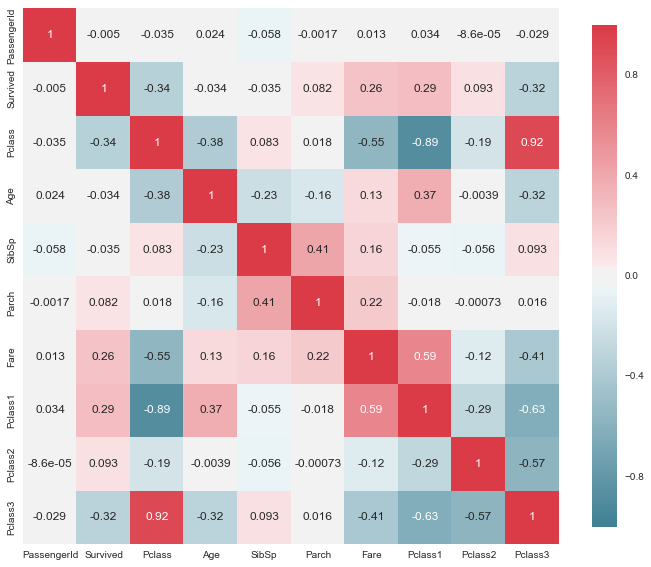

In [37]:
plot_correlation_map(df_data_viz)

In [34]:
corr = df.corr()
corr #shape = (6,6)

NameError: name 'df' is not defined

In [35]:
df_data_validation.loc[(df_data_validation.Pclass == 1), "Pclass1"] = 1
df_data_validation.loc[(df_data_validation.Pclass == 2), "Pclass2"] = 1
df_data_validation.loc[(df_data_validation.Pclass == 3), "Pclass3"] = 1
df_data_validation = df_data_validation.fillna(0)

## Check data imbalance

Can we improve the result with a better balancing of the data ?

### Going back to Graphlab SFrames

In [38]:
data = gl.SFrame(df_data)
data

PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Pclass1,Pclass2,Pclass3
1,0,3,22.0,1,0,7.25,0.0,0.0,1.0
2,1,1,38.0,1,0,71.2833,1.0,0.0,0.0
3,1,3,26.0,0,0,7.925,0.0,0.0,1.0
4,1,1,35.0,1,0,53.1,1.0,0.0,0.0
5,0,3,35.0,0,0,8.05,0.0,0.0,1.0
6,0,3,25.0,0,0,8.4583,0.0,0.0,1.0
7,0,1,54.0,0,0,51.8625,1.0,0.0,0.0
8,0,3,2.0,3,1,21.075,0.0,0.0,1.0
9,1,3,27.0,0,2,11.1333,0.0,0.0,1.0
10,1,2,14.0,1,0,30.0708,0.0,1.0,0.0


In [39]:
data_for_validation = gl.SFrame(df_data_validation)
data_for_validation

PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Is_baby,Pclass1,Pclass2,Pclass3
892,3,male,34.5,0,0,7.8292,0,0.0,0.0,1.0
893,3,female,47.0,1,0,7.0,0,0.0,0.0,1.0
894,2,male,62.0,0,0,9.6875,0,0.0,1.0,0.0
895,3,male,27.0,0,0,8.6625,0,0.0,0.0,1.0
896,3,female,22.0,1,1,12.2875,0,0.0,0.0,1.0
897,3,male,14.0,0,0,9.225,0,0.0,0.0,1.0
898,3,female,30.0,0,0,7.6292,0,0.0,0.0,1.0
899,2,male,26.0,1,1,29.0,1,0.0,1.0,0.0
900,3,female,18.0,0,0,7.2292,0,0.0,0.0,1.0
901,3,male,21.0,2,0,24.15,0,0.0,0.0,1.0


# Defining features, target 

In [44]:
#features = ["Sex", "Pclass1","Pclass2","Pclass3", "Is_baby", "Age"]
features = ["Pclass", "Fare"]
target = "Survived"
features

['Pclass', 'Fare']

## Splitting data into training and validation sets

In [45]:
train_data, validation_data = data.random_split(.8, seed=1)

# Model

In [46]:
model = tree_model(train_data,features,MLR=0.2, MCW=0)

In [47]:
#Optimizing min_loss_reduction
np.linspace(0,1,num=10)

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
        0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ])

In [48]:
train_acc = []
valid_acc = []
end = 2
nb = 100
mlr=1
for mcw in np.linspace(0,end,nb):
    model_MLR = tree_model(train_data,features,mlr,mcw)
    #print "Training accuracy", model_MLR.get('training_accuracy')
    prediction_validation = model.predict(validation_data)
    #print "Validation accuracy", calc_accuracy(prediction_validation,validation_data)
    train_acc.append(model_MLR.get('training_accuracy'))
    valid_acc.append(calc_accuracy(prediction_validation,validation_data))

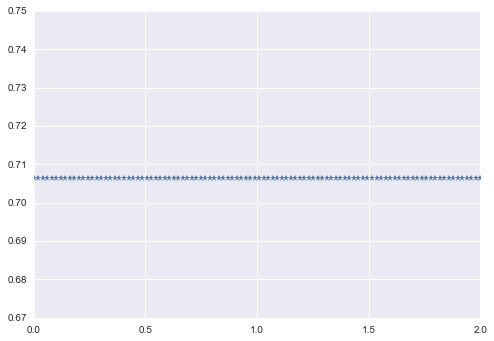

In [49]:
plt.plot(np.linspace(0,end,nb),train_acc,'*')

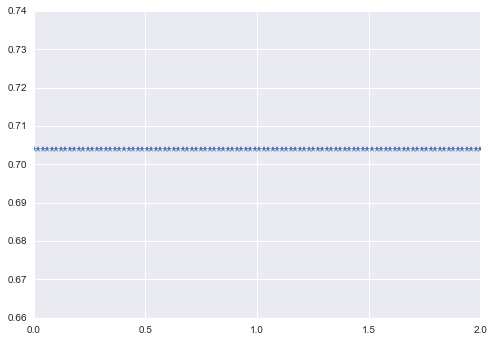

In [50]:
plt.plot(np.linspace(0,end,nb),valid_acc,'*')

In [51]:
prediction_validation = model.predict(validation_data)
prediction_validation

dtype: int
Rows: 179
[0L, 1L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 0L, 1L, 1L, 0L, 1L, 0L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 1L, 1L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 0L, 1L, 0L, 1L, 1L, 0L, 1L, 0L, 0L, 0L, 0L, 0L, 0L, 1L, 0L, 0L, 0L, 0L, 1L, 0L, 0L, 1L, 1L, 1L, 0L, 1L, 1L, 0L, 0L, 0L, 1L, 1L, 1L, 0L, 0L, 0L, ... ]

In [52]:
model.show(view = "Tree")

In [53]:
model_MLR.show(view="Tree")

## Estimating error on validation data

#### Error / accuracy

In [ ]:
calc_accuracy(prediction_validation,validation_data)

# Prediction using the validation data without ground truth

In [ ]:
prediction = model.predict(data_for_validation)

# Working with cross validation

First, shuffle data

In [ ]:
data_shuffled = gl.cross_validation.shuffle(data)

We split the data into a k-set of train/validation data (here k = 5).

folds is a kx2 array where folds[k][0] is the train set and folds[k][1] the validation set

In [ ]:
k = 10
folds = gl.cross_validation.KFold(data_shuffled,k)

We can check that the length of one fold is that of the total data

In [ ]:
print "Size of train/validation set in the fold", len(folds[0][0])+len(folds[0][1])
print "Size of the initial data", len(data)


In [ ]:
acc_sum=0
for train,valid in folds:
    #m = gl.decision_tree_classifier.create(train,target="Survived",validation_set=None,verbose=None)
    m = gl.decision_tree_classifier.create(train,target="Survived",validation_set=valid,verbose=None
                                          , min_loss_reduction = 0.2,min_child_weight = 0 )
    #print "EVALUATION", m.evaluate(valid) #Direct evaluation of the model on the validation set
    #print "PREDICTION", m.predict(valid) #Prediction of survival using the model
    #accuracy = m.evaluate(valid, metric='accuracy')
    #acc = accuracy['accuracy'] #accuracy is a dict so we need this step to extract a float
    #acc = calc_accuracy(m.predict(valid),valid)
    acc = m.get("validation_accuracy")
    acc_sum+=acc
    print("Accuracy of the model : %.6f" %acc)

print "Average accuracy on %0.f validation sets: %f " %(k ,(acc_sum/k))

# Exporting result as a csv file for submission

In [ ]:
result = gl.SFrame({'PassengerId':data_for_validation['PassengerId'],"Survived":prediction})
result

In [ ]:
#File exportation
result.export_csv("gender_submission9.csv")

# Notes

#Modèle simple : 2 features seulement (Classe et Sexe) : precision = 0.771 score = 0.76555
Modèle avec 3 features (Classe, Sexe, SibSp) : precision = 0.777 / score = 0.75598


In [ ]:
#En rajoutant l'age ! score = 0.76555

In [ ]:
#Si je prends Sexe, Classe et Is_baby au lieu de l'age j'obtiens la même chose

In [ ]:
#6 - j'ai crée 3 catégories pour la classe et pris "Age", Class1, class2, class3, sexe

In [ ]:
#7 - features = ["Sex", "Pclass1","Pclass2","Pclass3", "Is_baby"] (score = 0.77512)

In [ ]:
#8 - features = ["Sex", "Pclass1","Pclass2","Pclass3", "Is_baby", "Age"]
# Average accuracy on 10 validation sets: 0.813733 
# Score = 0.76077

In [ ]:
#9 - features = ["Pclass", "Fare", "Sex", "Age"]

Different mask filters are defined below

In [ ]:
#data.fillna("Age",0)
#data['Age'] = data["Age"].apply(age_change)
#data[data["Age"]<26]
#data["Age"][data["Age"]<26]
#if data["Fare"]==0 and data["Age"]==None:
#    data['Age_corr'] = data['Age'].apply(lambda x : 0 if x<1 else x)
#mask = data["Fare"]== 0
#mask2 = data["Age"]==None
#mask3 = (data["Fare"]== 0) & (data["Age"]==None)
mask_Age_Fare_zero = (data["Age"]==None)&(data["Fare"]==0)